This initial code installs and imports necessary packages to run the program.

In [1]:
GOOGLE_COLAB = True

In [2]:
if not GOOGLE_COLAB:
    %cd ../
else:
    !pip install git+https://github.com/easel-uci/pendsim.git

  Cloning https://github.com/easel-uci/pendsim.git to /private/var/folders/k0/b23vl_1x1rj9rdyyydnn0xt40000gn/T/pip-req-build-69adf6k7
  Running command git clone --filter=blob:none --quiet https://github.com/easel-uci/pendsim.git /private/var/folders/k0/b23vl_1x1rj9rdyyydnn0xt40000gn/T/pip-req-build-69adf6k7
  Resolved https://github.com/easel-uci/pendsim.git to commit 0f97dce35f539fb022d9d5c24ceb406b538e5319
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
from pendsim import sim, controller, viz
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

# PID Notebook

PID, or proportional-integral-derivative, control is a model-free feedback policy which uses an error signal and tunable gains to compute a control action that produces a desired system response.

![PID.png](https://github.com/rland93/pendsim/blob/master/notebooks/PID.png?raw=1)

The block diagram of the PID system in the time domain is shown above. Given the error signal $e(t)$, we tune the three gains, $K_p, K_i$ and $K_d$, to generate the control signal, $u(t)$. The control signal is an input to the physical system (the *plant / process*), which finally produces some output $y(t)$. (Graphic is sourced from Wikipedia).

For more information about PID control, see [Feedback Systems:
An Introduction for Scientists and Engineers, Ch 10](https://people.duke.edu/~hpgavin/SystemID/References/Astrom-Feedback-2006.pdf), or for a less technical introduction, [Wikipedia](https://en.wikipedia.org/wiki/PID_controller).

---
#Part 1: System Analysis
Consider the inverted pendulum on a cart system. The cart can move horizontally, and the pendulum is free to rotate about the point that it is attached to the cart. For simplicity, let's neglect friction and inertia. 

The system has the following parameters:
*   $M$ = mass of the cart
*   $m$ = mass on the end of the pendulum
*   $l$ = length of the pendulum
*   $g$ = gravity

The system's states that vary with time are:
*   $x$ = cart position
*   $\dot x$ = cart velocity
*   $\theta$ = pendulum angle (where $\theta=0$ corresponds to the upright position)
*   $\dot\theta$ = pendulum angular velocity

And some horizontal force or "push" of the cart is given by $u$.

The linearized system can be modeled in the time domain as 

$${\bf \dot x} = A{\bf x} + Bu $$

Written out, this is  
$$
\begin{bmatrix} \dot{x}\\ \ddot{x}\\ \dot{\theta}\\ \ddot{\theta}\end{bmatrix}  =
\begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & 0 &\frac{m g}{M} & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & \frac{g (M+m)}{Ml} & 0 \\
\end{bmatrix} 
\begin{bmatrix} x\\ \dot{x}\\ \theta\\ \dot{\theta}\end{bmatrix}  
+
\begin{bmatrix}
0 \\
\frac{1}{M} \\ 
0 \\
\frac{1}{Ml} \\
\end{bmatrix}
u
$$

Assuming we can measure the angle $\theta$, our goal is to design a proportional-derivative (PD) controller that can stabilize an inverted pendulum on a cart in the upright position (i.e., $\theta=0$) when it is released from rest at a certain angle different from the upright position (i.e., $\theta \neq 0$). 

Therefore, we will consider a control law of the form
$$u(t) = k_p e(t) + k_d \dot e(t)$$
where $e(t)=\theta_d(t)-\theta(t)$ is the error signal that is equal to the difference between the desired angle ($\theta_d=0$ in the upright position) and the measured angle $\theta$. 

In the code below, define your system. Choose values for the mass of the cart (choose something between 0.1kg and 10kg), the mass on the end of the pendulum (choose something between 0.1kg and 10kg), and the length of the pendulum (choose something between 0.1 and 3 meters).

## Include the following in your report:
*   Write down the closed-loop transfer function relating the output $\theta$ to the input $\theta_d$. 
*   Write down the poles of the closed-loop system as a function of the control gains and model parameters.
*   What is the condition on $k_p$ such that the poles are complex (i.e., for what values of $k_p$ will the poles have non-zero imaginary parts)?
*   Write down the parameter values you chose. 

In [4]:
pend = sim.Pendulum(
    1.0, # Pendulum base mass [kg] - CHANGE THIS VALUE
    1.0, # Pendulum ball mass [kg] - CHANGE THIS VALUE
    1.0, # Pendulum length [m] - CHANGE THIS VALUE
    
    # state = [x [m], xdot [m/s], theta [rad], thetadot [rad/s]]
    initial_state = np.array([0.0, 0.0, 0.1, 0.0]) 
    # MAY CHANGE THIRD VALUE IN THIS ARRAY TO A DIFFERENT SMALL VALUE.
    # YOU WILL CHANGE THIS VALUE AGAIN AFTER TUNING A PD CONTROLLER.
)

dt, t_final = 0.01, 10 # time step and simulation time [s]
# define the force that is applied to the cart [N] - don't worry about this function
def force_func(t):
    return 0 
simu10 = sim.Simulation(dt, t_final, force_func)

---
#Part 2: Controller Design

A PID controller has three gains, that we call `kp`, `ki`, `kd` here. These are also called the proportional, integral, and derivative gains, respectively.

To start, set all the gains equal to zero. This zero-gain controller fails to stabilize the pendulum system because all of the coefficients in front of the actuation are 0! So, with all gains equal to 0, the controller takes no action at all. Therefore, $\theta$ increases, and the pendulum simply falls over. The plot shows $\theta$ changing from 0 to $2\pi$ radians as the pendulum swings around and around since there is no friction or inertia.

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5247.28it/s]


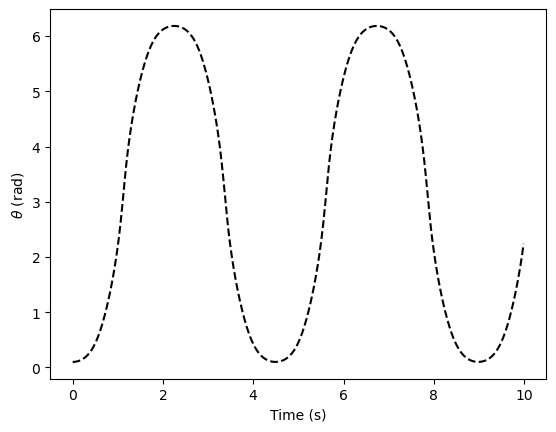

In [5]:
kp, ki, kd = 0.0, 0.0, 0.0 # control gain values
cont = controller.PID((kp, ki, kd))
results = simu10.simulate(pend, cont)
fig1, ax1 = plt.subplots()
ax1.plot(results[('state','t')], 'k--', label='theta')
plt.ylabel(r"$\theta$ (rad)")
plt.xlabel("Time (s)")
plt.show()

And for a visual confirmation of our suspicion, we visualize the virtual experiment:

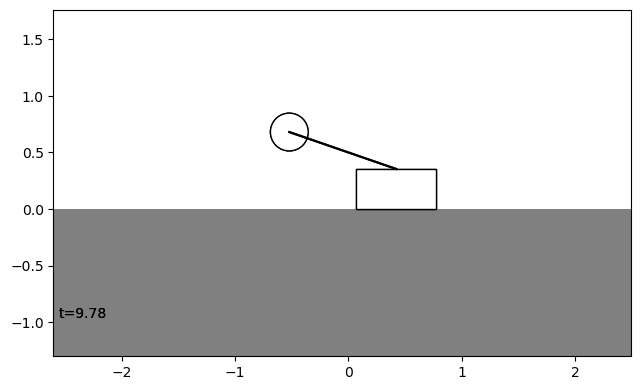

In [6]:
visu = viz.Visualizer(results, pend, dt)
ani = visu.animate()
HTML(ani.to_html5_video())

To tune the PID controller, start by changing the proportional gain, called `kp`. Start at zero and slowly increase it to see what happens. Let's create several controllers, increasing the gain $k_p$ for each controller. Feel free to change this in the code below. Our ultimate goal is to stabilize the pendulum system in the upright position, so that means we want $\theta$ to settle at 0 radians.

In [7]:
# starting gain
kp = 0.0
# number of times to increase the gain
n = 32
# amount to increase by
increase_by = 1.5 # YOU CAN CHANGE THIS
# empty lists
conts = []
pends = [pend] * n
gains = []
for _ in range(n):
    # increase the gain
    kp += increase_by
    # set ki, kd to 0
    pid = kp, 0.0, 0.0
    conts.append(controller.PID(pid))
    gains.append(kp)
# simulate each controller
all_results = simu10.simulate_multiple(pends, conts)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5468.87it/s]


Now, let's simulate the system and plot the values of $\theta$ for each gain.

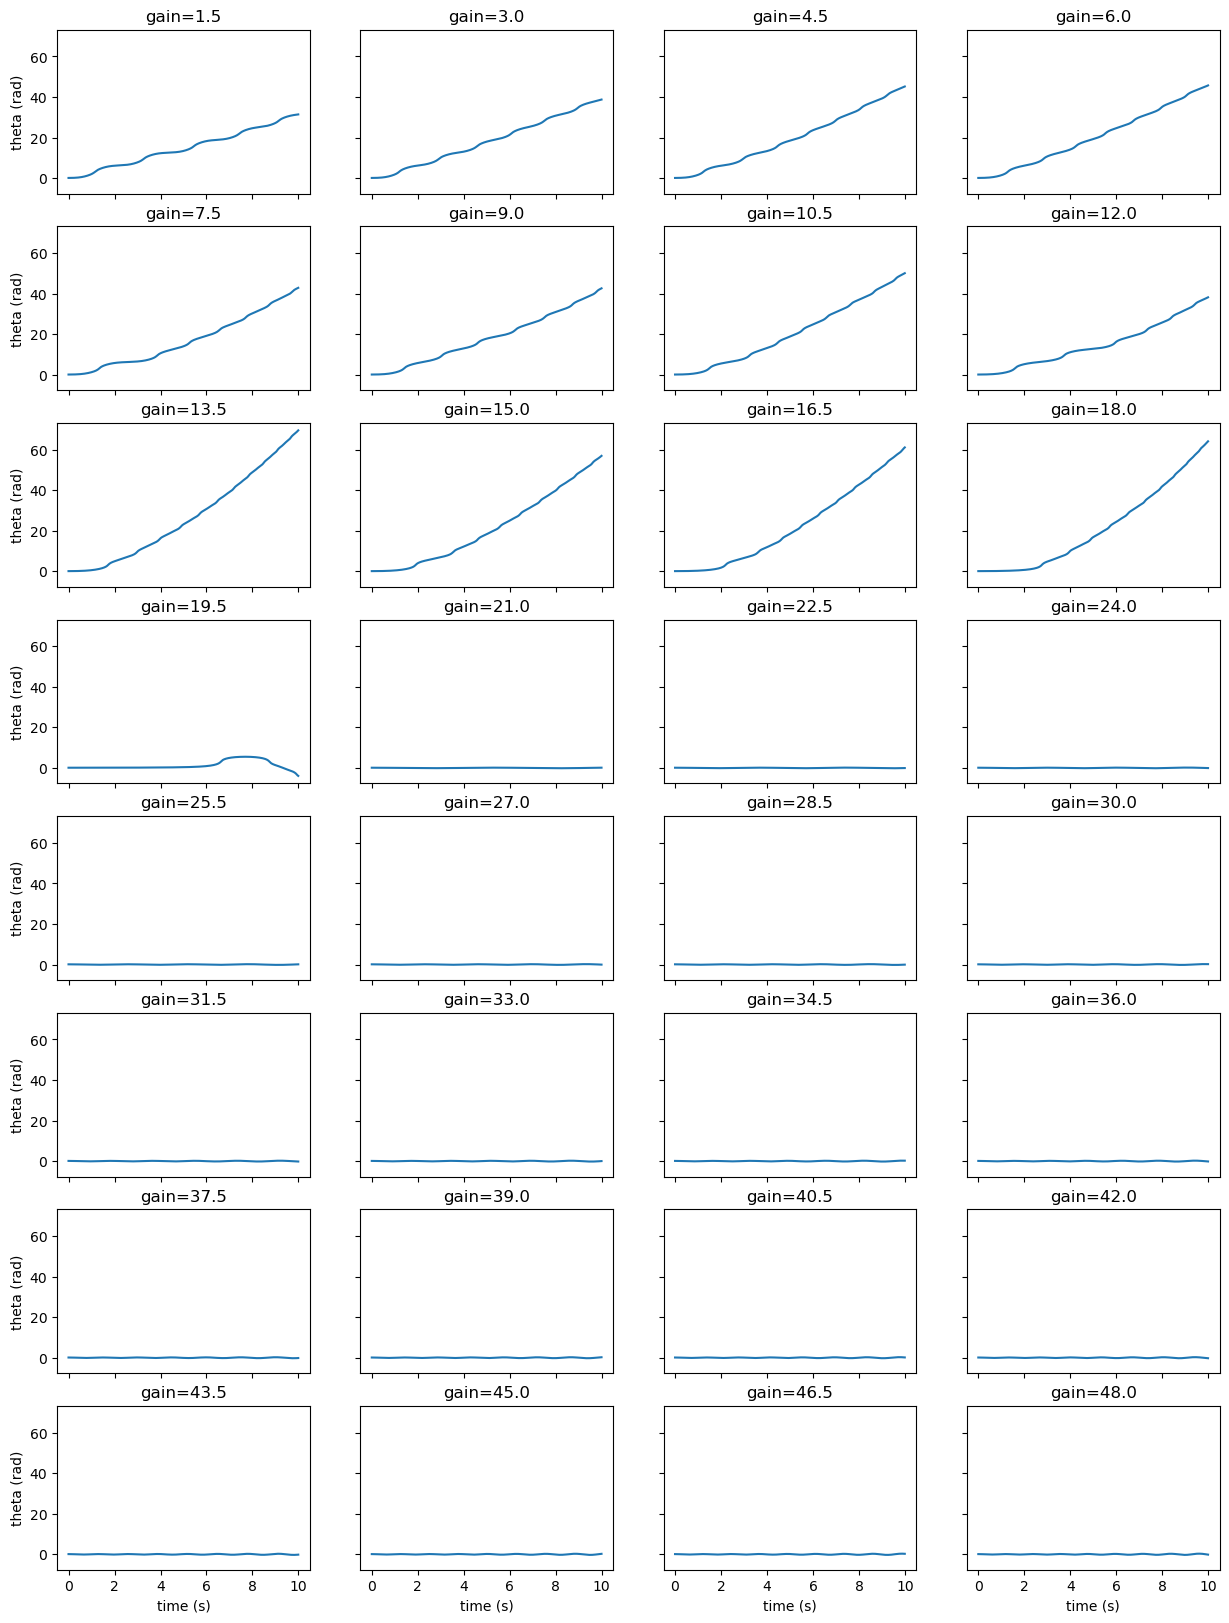

In [8]:
nrows, ncols = 8, 4
fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(15,20))
axn, ax_idxs = 0, {}
# index helper map for plots
for i in range(nrows):
    for j in range(ncols):
        ax_idxs[axn] = (i, j)
        axn += 1
# create figures and set the title as the gain
for g, (idx, res), (axi, axj) in zip(gains, all_results.groupby(level=0), ax_idxs.values()):
    res.index = res.index.droplevel(0)
    ax1[axi, axj].plot(res[('state', 't')])
    ax1[axi, axj].set_title('gain=' + str(g))
# label figures
for i in range(nrows):
    ax1[i, 0].set_ylabel('theta (rad)')
for j in range(ncols):
    ax1[-1, j].set_xlabel('time (s)')
plt.show()

We can see that the controller keeps the pendulum's angle close to zero with a large enough $k_p$. Set $k_p$ to this value in the code below.

These results should make intuitive sense with a bit of control systems knowledge: increasing the proportional gain makes the system respond faster and also increases the frequency of oscillation.

The pendulum is (somewhat) stable around $\theta=0$, but we still have a pesky oscillation. Can we remove it?

There is one more thing going on here. It appears that the system is oscillating but also that the oscillations are increasing in magnitude. Eventually, this instability will compound enough to topple the pendulum, despite having a proportional controller in place with a suitable gain. To see this, we can increase the simulation time, this time to 40 seconds instead of 10.

In [9]:
kp = 30.0 # CHANGE THIS TO A REASONABLE VALUE YOU FOUND WHEN TUNING ABOVE
cont = controller.PID( (kp, 0, 0) )
simu30 = sim.Simulation(dt, 40, force_func)
res_proportional = simu30.simulate(pend, cont)

100%|█████████████████████████████████████| 4000/4000 [00:00<00:00, 5686.35it/s]


And we plot our longer-term simulation:

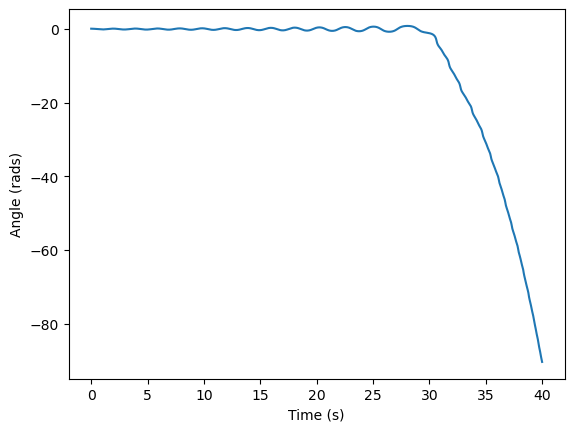

In [10]:
_, ax = plt.subplots()
ax.plot(res_proportional[('state', 't')])
ax.set_ylabel("Angle (rads)")
ax.set_xlabel("Time (s)")
plt.show()

We see that eventually the oscillation grows large enough that the inverted pendulum falls over. The controller pushes a little bit too hard right, and the pendulum overshoots a bit to the left; then, the controller pushes left, and the pendulum overshoots a bit (more!) to the right, and the process continues until the pendulum tips over.

This looks like a response associated with a complex pole with positive real part: a steady oscillation bounded by an envelope of an increasing exponential -- that is, until the pendulum falls over. This is due to the non-zero initial angle.

We need damping! A derivative term seeks to drive the rate of change of the error closer to zero over time. Practically, this means that it can counteract the magnitude of the steady oscillation we see (i.e., add damping to the system), and as a result, stabilize the system. 

Below, we follow the same experimental process for tuning: slowly increase $k_d$ and see the effects. In real-life systems, where failure can have expensive or dangerous consequences, tuning is a very delicate process, typically informed heavily by process knowledge. In this simulated world, we have no such concerns. 

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2804.80it/s]


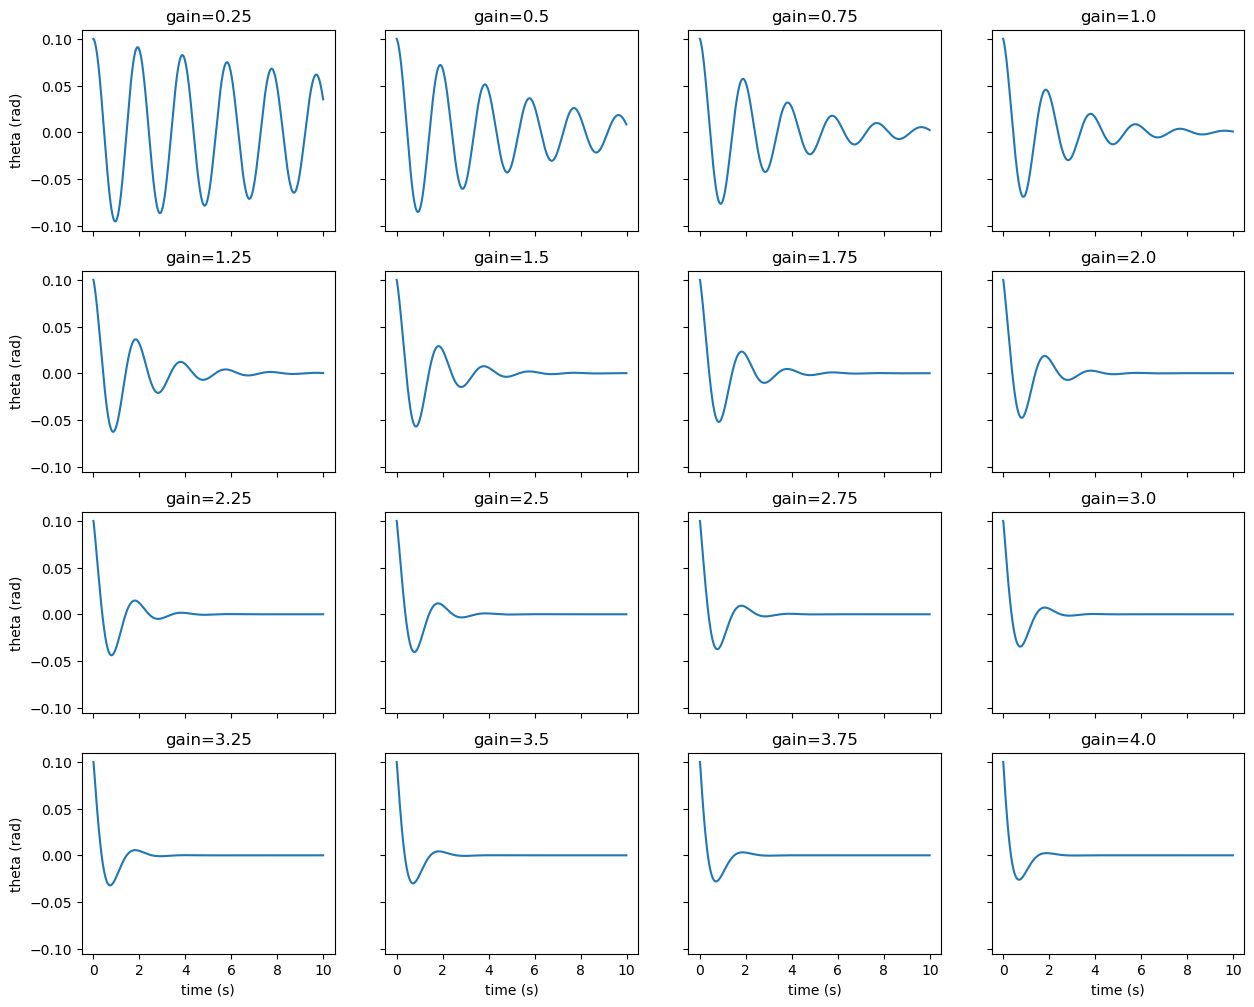

In [11]:
kp = 30.0 # CHANGE THIS TO A REASONABLE VALUE YOU FOUND WHEN TUNING ABOVE 
kd = 0.0
n = 16
increase_by = 0.25 # YOU CAN CHANGE THIS
conts = []
pends = [pend] * n
gains = []
for _ in range(n):
    # increase the gain
    kd += increase_by
    # set ki, kd to 0
    pid = kp, 0.0, kd
    conts.append(controller.PID(pid))
    gains.append(kd)
# simulate each controller
all_results = simu10.simulate_multiple(pends, conts)

nrows, ncols = 4, 4
fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(15,12))
axn, ax_idxs = 0, {}
for i in range(nrows):
    for j in range(ncols):
        ax_idxs[axn] = (i, j)
        axn += 1
for g, (idx, res), (axi, axj) in zip(gains, all_results.groupby(level=0), ax_idxs.values()):
    res.index = res.index.droplevel(0)
    ax1[axi, axj].plot(res[('state', 't')])
    ax1[axi, axj].set_title('gain=' + str(g))
# label plots
for i in range(nrows):
    ax1[i, 0].set_ylabel('theta (rad)')
for j in range(ncols):
    ax1[-1, j].set_xlabel('time (s)')

plt.show()

Now, we look again at $\theta$. It looks significantly better! The addition of a derivative term drives the oscillations towards zero. To see the effect, we plot the two controllers next to one another, one with the $k_d$ term and one without. 

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5863.86it/s]


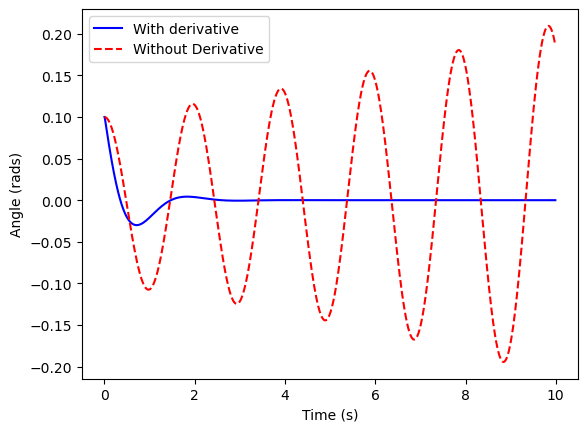

In [12]:
res_p_10 = simu10.simulate(pend, controller.PID((30, 0.0, 0.0))) 
# Arguments in controller.PID are PID gains (kp, ki, kd)
# CHANGE THESE GAINS TO THOSE THAT YOU EXPERIMENTALLY FOUND TO WORK WELL.
# CHANGE ONLY kp ABOVE, BUT CHANGE BOTH kp AND kd BELOW.
res_pd_10 = simu10.simulate(pend, controller.PID((30, 0.0, 3.5)))

fig, ax = plt.subplots()
ax.plot(res_pd_10[('state', 't')], 'b-', label='With derivative')
ax.plot(res_p_10[('state', 't')], 'r--', label='Without Derivative')
ax.set_ylabel('Angle (rads)')
ax.set_xlabel('Time (s)')
ax.legend()
plt.show()

The difference is stark!

Finally, we can look at a visualization of how this controller performed. 

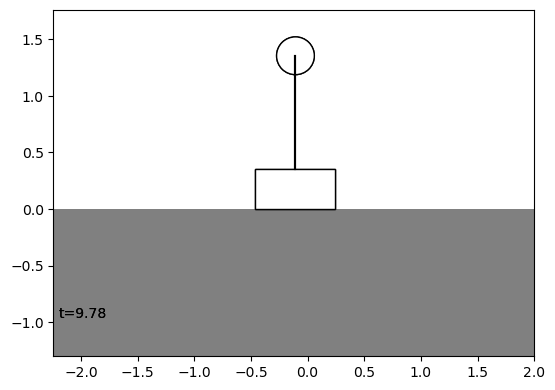

In [13]:
visu = viz.Visualizer(res_pd_10, pend, dt)
ani = visu.animate(blit=True)
HTML(ani.to_html5_video())

Since this simulation is relatively accurate, we expect that a pendulum with the same attributes (length, mass, etc.), if controlled by a controller with the same gain (as expressed in Newtons of force applied), would have similar stability characteristics -- so long as we could accurately measure the state!

Tuning a controller in simulation is common practice before implementing a controller in a physical system, where the consequences of bad tuning can be disasterous. If there were serious consequences to knocking over our pendulum, we would want to use the gains we have discovered here as a starting point.

## Include the following in your report:
*   Write down the final $k_p$ and $k_d$ values you chose that stabilize the system.
*   Given these gain values and the parameter values you chose, calculate the values of the poles of your closed-loop system and plot them on the complex plane. Drawing the figure by hand is fine. 
*   Is this system stable, marginally stable, or unstable? Is the system underdamped, critically damped, or overdamped?
*   Include the figure generated above that shows the comparison between responses with a P controller versus a PD controller.
*   Would adding an integral term to the control law (i.e., make it a PID controller rather than a PD controller) improve the performance of this closed-loop system? Describe why or why not. Feel free to experiment with $k_i$ values in the code.
*   Finally, change the initial condition for $\theta$ in Part 1 above. What is the largest initial angle for which this same PD controller you already tuned can stabilize the system? (You only need to update the initial condition in the code that defines 'pend' in Part 1, rerun that code, and rerun the code at the end of Part 2 that compares the P and PD controllers.)
*   Include the figure generated above comparing the P and PD controllers for this new initial condition.






